In [1]:
import geopandas as gpd
import pandas as pd
import re
import numpy as np
from PIL import Image
import requests
import sys
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB3

# Начальная обработка данных

## Получение наборов данных

### Чтение файла типа gpkg

In [2]:
input_file = "Vozrast_domov_SanktPeterburga.gpkg"
input_data = gpd.read_file(input_file)

In [6]:
print(input_data.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 142325 entries, 0 to 142324
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   r_adress         142010 non-null  object  
 1   r_years_string   80247 non-null   object  
 2   r_architect      10856 non-null   object  
 3   r_style          15725 non-null   object  
 4   r_name           126939 non-null  object  
 5   r_photo_url      38607 non-null   object  
 6   r_cw_url         22009 non-null   object  
 7   r_layer          142300 non-null  object  
 8   r_year_int       79602 non-null   float64 
 9   r_url            32 non-null      object  
 10  r_copyrights     142319 non-null  object  
 11  r_wikipedia_url  13 non-null      object  
 12  geometry         142325 non-null  geometry
dtypes: float64(1), geometry(1), object(11)
memory usage: 14.1+ MB
None


### Выберем нужные столбцы

In [6]:
df = input_data.loc[((input_data['r_photo_url'].notna()) & (input_data['r_style'].notna()) &(input_data['r_year_int'].notna()) & (input_data['r_style'] != "") & (input_data['r_style'] != " "))]
df = df[['r_photo_url','r_style', 'r_year_int']]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15053 entries, 68 to 142296
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   r_photo_url  15053 non-null  object 
 1   r_style      15053 non-null  object 
 2   r_year_int   15053 non-null  float64
dtypes: float64(1), object(2)
memory usage: 470.4+ KB
None


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15053 entries, 68 to 142296
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   r_photo_url  15053 non-null  object 
 1   r_style      15053 non-null  object 
 2   r_year_int   15053 non-null  float64
dtypes: float64(1), object(2)
memory usage: 470.4+ KB
None


In [8]:
df.to_csv('data_frame.csv', index = False, encoding = "utf-16")

Загрузим данные из csv

In [23]:
df = pd.read_csv('data_frame.csv', encoding = 'utf-16')
df = df.loc[(input_data['r_year_int'].notna())]
df = df[['r_photo_url','r_style', 'r_year_int']]

In [24]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6581 entries, 5 to 13018
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   r_photo_url  6581 non-null   object 
 1   r_style      6579 non-null   object 
 2   r_year_int   6579 non-null   float64
dtypes: float64(1), object(2)
memory usage: 205.7+ KB
None


Удалим строки с неработающими ссылками

In [5]:
for row_index, row in df.iterrows():
    try: 
        image = requests.get(df['r_photo_url'][row_index])
    except:
        print(row_index)
        df.drop(labels = [row_index], axis = 0)

298
686
1961
7662
8196
11407


In [8]:
df.drop(labels = [298, 686, 1961, 7662, 8196, 11407], axis = 0)

,r_photo_url,r_style,r_year_int
0,https://p1.citywalls.ru/photo_225-230545.jpg,Современный,2015.0
1,https://p2.citywalls.ru/photo_226-232202.jpg,Сталинский неоклассицизм,1953.0
2,https://p3.citywalls.ru/photo_302-309819.jpg,Рядовая застройка,1959.0
3,https://p1.citywalls.ru/photo_136-140041.jpg,Сталинский неоклассицизм,1952.0
4,https://p3.citywalls.ru/photo_181-186047.jpg,Современный,1959.0
...,...,...,...
13014,https://p2.citywalls.ru/photo_149-153082.jpg,Современный,1964.0
13015,https://p1.citywalls.ru/photo_192-197193.jpg,Современный,1972.0
13016,https://p0.citywalls.ru/photo_270-277128.jpg,Рядовая застройка,1918.0
13017,https://p3.citywalls.ru/photo_13-14207.jpg,Эклектика,1840.0


In [10]:
df.to_csv("data_frame.csv", encoding = 'utf-16', index = False)

In [58]:
df = pd.read_excel("data_frame_1.xlsx")


In [59]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13013 entries, 0 to 13012
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   r_photo_url  13013 non-null  object 
 1   r_style      13013 non-null  object 
 2   r_year_int   13013 non-null  float64
dtypes: float64(1), object(2)
memory usage: 305.1+ KB
None


Выделим список уникальных названий значений классов

In [60]:
print(df['r_style'].unique())

['Современный' 'Сталинский неоклассицизм' 'Рядовая застройка'
 'Конструктивизм' 'Эклектика' 'Классицизм' 'Модерн' 'Неорусский'
 'Неоклассицизм' 'Кирпичный' 'Необарокко' 'Псевдоготика' 'Неоренессанс'
 'Барокко' 'Ретроспективизм' 'модерн' 'Модернизм' 'Византийский'
 ' Современный' ' Сталинский неоклассицизм' ' Cовременный' 'модернизм'
 ' Конструктивизм' 'функционализм' 'конструктивизм' 'Неоклассицизм '
 ' Эклектика' ' Неорусский' 'эклектика' 'неоклассицизм' 'Псевдорусский '
 ' Модерн' 'Хрущевка' 'Северный модерн' ' Неоклассицизм'
 ' Петровское барокко' 'Петровское барокко' 'Сталинский неоклассицизм.']


## Глядя на названия классов, подправим датасет

In [61]:
for row_index, row in df.iterrows():
   df['r_style'][row_index] = re.sub(u'ё', u'e', df['r_style'][row_index]) #меняем буквы ё на е
   df['r_style'][row_index] = df['r_style'][row_index].strip() #убираем пробелы в начале и конце строк
   df['r_style'][row_index] = df['r_style'][row_index].title() #делаем все буквы слов заглавными
   df['r_style'][row_index] = df['r_style'][row_index].replace(".","") #убираем точки из строк
   df['r_style'][row_index] = df['r_style'][row_index].replace('Современный', 'Рядовая Застройка') #меняем "современный" на "рядовая застройка" (де-факто это одно и то же)
   # print(row_index, row)

C:\Users\Acer\AppData\Local\Temp\ipykernel_9572\441623882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r_style'][row_index] = re.sub(u'ё', u'e', df['r_style'][row_index]) #меняем буквы ё на е
C:\Users\Acer\AppData\Local\Temp\ipykernel_9572\441623882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r_style'][row_index] = df['r_style'][row_index].strip() #убираем пробелы в начале и конце строк
C:\Users\Acer\AppData\Local\Temp\ipykernel_9572\441623882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

# Исходная версия проекта

### Получим названия классов

In [62]:
classes = df['r_style'].unique()
print(classes)

['Рядовая Застройка' 'Сталинский Неоклассицизм' 'Конструктивизм'
 'Эклектика' 'Классицизм' 'Модерн' 'Неорусский' 'Неоклассицизм'
 'Кирпичный' 'Необарокко' 'Псевдоготика' 'Неоренессанс' 'Барокко'
 'Ретроспективизм' 'Модернизм' 'Византийский' 'Cовременный'
 'Функционализм' 'Псевдорусский' 'Хрущевка' 'Северный Модерн'
 'Петровское Барокко']


In [63]:
df_classes = df.groupby(['r_style']).count().reset_index()
df_classes['r_photo_url']

0        1
1       42
2       11
3      584
4      669
5      407
6     1088
7        5
8       71
9      405
10      83
11     123
12       2
13      50
14       1
15     207
16    5622
17       1
18    2025
19       1
20       1
21    1614
Name: r_photo_url, dtype: int64

In [64]:
df_classes = df_classes.loc[(df_classes['r_photo_url'] >= 400)]

In [65]:
classes = df_classes['r_style']
df = df.loc[(df['r_style'].isin(classes))]

Прочитаем фото по ссылкам 

In [42]:
for row_index, row in df.iterrows():
      try:
            p = requests.get(df['r_photo_url'][row_index])
            out = open(f"G:\photos_buildings\\image_{row_index}.jpg", "wb")
            out.write(p.content)
            out.close()
      except:
            print('-')

-
-
-
-


### Прочитаем фотографии из папки 

In [67]:
data = []
error_index = []

flag = 0 #флаг проверяет наличие некорректных данных изображения
for row_index, row in df.iterrows():
      try:
            image = Image.open(f'G:\photos_buildings\\image_{row_index}.jpg')
            image = image.resize((150,150))
            image = img_to_array(image)
            for i in range (0, len(image)):
                  for j in range (0, len(image[i])):
                        if len(image[i][j]) != 3:
                              error_index.append(row_index)
                              flag = 1
                              break
                        else:
                              flag = 0
            if flag == 0: 
                  data.append(image)
      except:
            error_index.append(row_index)

In [68]:
sys.getsizeof(data)

85176

In [69]:
df = df.drop(labels = error_index, axis = 0)

Определяем метки для архитектурного стиля

In [70]:
labels = []
for row_index, row in df.iterrows():
    labels.append(np.where(classes==df['r_style'][row_index])[0][0])

labels = np.array(labels)

Определяем возраст зданий

In [72]:
ages = 2024.0 - df['r_year_int']
ages = np.array(ages)

In [73]:
photos = np.array(data)
photos /= 255.0

Смотрим количество изображений в каждом классе

In [76]:
np.unique(labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([ 531,  554,  379,  770,  292, 5169, 1869, 1053], dtype=int64))

Получем список классов

In [77]:
classes = df_classes['r_style']
classes.reset_index(drop= True , inplace= True)

Строим гистаграммы распределений показателей

In [ ]:
plt.hist(labels,  color = 'blue', edgecolor = 'black')
plt.title('Распределение классов стилей зданий')

In [ ]:
plt.hist(ages,  color = 'teal', edgecolor = 'black' )
plt.title('Распределение зданий по возрастам')

## Создаем и обучаем модель

In [79]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(photos, labels, ages, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, z_train.shape, z_test.shape)

(8493, 150, 150, 3) (2124, 150, 150, 3) (8493,) (2124,) (8493,) (2124,)


### Архитектурный стиль

Строим модель

In [80]:
class NetStyle:
  @staticmethod
  def build(width, height, depth, classes):
    model_style = Sequential()
    inputShape = (height, width, depth)
    if K.image_data_format() == 'channels_first':
      inputShape = (depth, height, width)
    model_style = Sequential()

    model_style.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=inputShape))
    model_style.add(MaxPool2D(pool_size=(2, 2)))
    model_style.add(Dropout(rate=0.5))

    model_style.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model_style.add(MaxPool2D(pool_size=(2, 2)))
    model_style.add(Dropout(rate=0.5))

    model_style.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model_style.add(MaxPool2D(pool_size=(2, 2)))
    model_style.add(Dropout(rate=0.5))

    model_style.add(Flatten())
    model_style.add(Dense(1000, activation='relu'))
    model_style.add(Dropout(rate=0.35))
    model_style.add(Dense(classes, activation='softmax'))
    return model_style

Обучаем модель

In [81]:
epochs = 35
model_style = NetStyle.build(width=150, height=150, depth=3, classes=8)
model_style.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_style.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/35
133/133 [==============================] - 427s 3s/step - loss: 2.2765 - accuracy: 0.4687 - val_loss: 1.7623 - val_accuracy: 0.4911
Epoch 2/35
133/133 [==============================] - 388s 3s/step - loss: 1.5553 - accuracy: 0.4869 - val_loss: 1.5548 - val_accuracy: 0.5009
Epoch 3/35
133/133 [==============================] - 381s 3s/step - loss: 1.4949 - accuracy: 0.4963 - val_loss: 1.4831 - val_accuracy: 0.5264
Epoch 4/35
133/133 [==============================] - 373s 3s/step - loss: 1.4445 - accuracy: 0.5142 - val_loss: 1.4561 - val_accuracy: 0.5193
Epoch 5/35
133/133 [==============================] - 374s 3s/step - loss: 1.4142 - accuracy: 0.5251 - val_loss: 1.4536 - val_accuracy: 0.5311
Epoch 6/35
133/133 [==============================] - 379s 3s/step - loss: 1.3760 - accuracy: 0.5362 - val_loss: 1.3998 - val_accuracy: 0.5235
Epoch 7/35
133/133 [==============================] - 382s 3s/step - loss: 1.3443 - accuracy: 0.5424 - val_loss: 1.3674 - val_accuracy: 0.5372

In [ ]:
model_style.save('model_style.keras')

### Возраст здания по фото

Строим модель

In [98]:
class Net_Ages:
  @staticmethod
  def build(width, height, depth):
    model_ages = Sequential()
    inputShape = (height, width, depth)
    if K.image_data_format() == 'channels_first':
      inputShape = (depth, height, width)
    model_ages = Sequential()
    
    model_ages.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=inputShape))
    model_ages.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=inputShape))
    model_ages.add(MaxPool2D(pool_size=(2, 2)))
    model_ages.add(Dropout(rate=0.5))

    model_ages.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model_ages.add(MaxPool2D(pool_size=(2, 2)))
    model_ages.add(Dropout(rate=0.5))

    model_ages.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model_ages.add(MaxPool2D(pool_size=(2, 2)))
    model_ages.add(Dropout(rate=0.5))

    model_ages.add(Flatten())
    model_ages.add(Dense(64, activation='relu'))
    model_ages.add(Dense(1, activation='relu')) 
    return model_ages

Обучаем модель

In [101]:
epochs = 35
model_ages = Net_Ages.build(width=150, height=150, depth=3)
model_ages.compile(loss='mean_squared_error', optimizer='adam',
               metrics=['mae'])
history_ages = model_ages.fit(X_train, z_train, batch_size=64, validation_data=(X_test, z_test), epochs=epochs)


Epoch 1/35
133/133 [==============================] - 547s 4s/step - loss: 2880.5242 - mae: 41.7086 - val_loss: 4426.6064 - val_mae: 52.5945
Epoch 2/35
133/133 [==============================] - 553s 4s/step - loss: 2550.7305 - mae: 38.8315 - val_loss: 3288.1558 - val_mae: 44.2121
Epoch 3/35
133/133 [==============================] - 545s 4s/step - loss: 2338.3391 - mae: 36.9941 - val_loss: 4091.3979 - val_mae: 50.1537
Epoch 4/35
133/133 [==============================] - 546s 4s/step - loss: 2270.0786 - mae: 36.2966 - val_loss: 3648.9922 - val_mae: 46.5734
Epoch 5/35
133/133 [==============================] - 547s 4s/step - loss: 2222.9175 - mae: 35.7188 - val_loss: 3672.1970 - val_mae: 46.7382
Epoch 6/35
133/133 [==============================] - 548s 4s/step - loss: 2210.0847 - mae: 35.6498 - val_loss: 2938.7458 - val_mae: 41.1512
Epoch 7/35
133/133 [==============================] - 553s 4s/step - loss: 2089.9663 - mae: 34.5923 - val_loss: 3192.6743 - val_mae: 43.1286
Epoch 8/35
13

In [130]:
model_ages.save('model_ages.keras')

## Смотрим результаты

In [ ]:
model_style = load_model('model_style.keras')
model_ages = load_model('model_ages.keras')

In [ ]:
predicted_style = model_style.predict(X_test)
predicted_age = model_ages.predict(X_test)

In [ ]:
index = 1028
plt.imshow(X_test[index])
plt.title(f'Точно: {int(z_test[index])}, {classes[y_test[index]]}, Предсказано: {int(predicted_age[index])}, {classes[np.argmax(predicted_style[index])]}')

## Определение наличия у здания архитектурной ценности

In [ ]:
# Функция, определеяющая "ценность здания"
# Минимальное количество баллов - 0, максимальное 100
def Significance(age, num_class):
    result = 0

    #На основе датировки
    #Архитектура 1950-1970гг
    if(age > 50 and age < 70):
        result += 10
    #Сталинская архитектура и довоенная архитектура
    elif(age >= 70 and age < 107):
        result += 25
    #Дореволюционная архитектура с 1870-х годов
    elif(age >= 95 and age < 154):
        result += 40
    #Более ранняя архитектура
    elif(age >= 154):
        result+= 50
    else:
        result+= 0

    #На основе культурного стиля 
    #За рядовую застройку баллов не добавляется
    if(num_class == 5):
        result+= 0 
    #За кирпичный стиль
    elif(num_class == 0):
        result+= 10
    #Сталинский неоклассицизм
    elif(num_class == 6):
        result+= 30
    #Остальные архитектурные стили (представлены в основном в дореволюционную эпоху)
    else:
        result+= 50

    return result


In [ ]:
exact_significance = []
predicted_significance = []
for index in range(0, len(y_test)):
    exact_significance.append(Significance(z_test[index], y_test[index]))
    predicted_significance.append(Significance(predicted_age[index], np.argmax(predicted_style[index])))

In [ ]:
index = 1444
plt.imshow(X_test[index])
plt.title(f'Точно: {exact_significance[index]}, Предсказано: {predicted_significance[index]}')

# Улучшенная версия проекта

## Работа с датасетом

In [ ]:
classes = df['r_style'].unique()
print(classes)

['Рядовая Застройка' 'Сталинский Неоклассицизм' 'Конструктивизм'
 'Эклектика' 'Классицизм' 'Модерн' 'Неорусский' 'Неоклассицизм'
 'Кирпичный' 'Необарокко' 'Псевдоготика' 'Неоренессанс' 'Барокко'
 'Ретроспективизм' 'Модернизм' 'Византийский' 'Cовременный'
 'Функционализм' 'Псевдорусский' 'Хрущевка' 'Северный Модерн'
 'Петровское Барокко']


In [ ]:
df_classes = df.groupby(['r_style']).count().reset_index()

In [ ]:
df_classes = df_classes.loc[(df_classes['r_photo_url'] >= 600)]
classes = df_classes['r_style']
df = df.loc[(df['r_style'].isin(classes))]
df = df.loc[(df['r_year_int'] >= 1824)]

In [ ]:
data = []
error_index = []

flag = 0 #флаг проверяет наличие некорректных данных изображения
for row_index, row in df.iterrows():
      try:
            image = Image.open(f'G:\photos_buildings\\image_{row_index}.jpg')
            image = image.resize((255,255))
            image = img_to_array(image)
            for i in range (0, len(image)):
                  for j in range (0, len(image[i])):
                        if len(image[i][j]) != 3:
                              error_index.append(row_index)
                              flag = 1
                              break
                        else:
                              flag = 0
            if flag == 0: 
                  data.append(image)
      except:
            error_index.append(row_index)

In [ ]:
df = df.drop(labels = error_index, axis = 0)
labels = []
for row_index, row in df.iterrows():
    labels.append(np.where(classes==df['r_style'][row_index])[0][0])

labels = np.array(labels)
ages = 2024.0 - df['r_year_int']
ages = np.array(ages)
photos = np.array(data)
photos /= 255.0

In [ ]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(photos, labels, ages, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, z_train.shape, z_test.shape)

In [ ]:
np.save('x_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('z_train.npy', z_train)

np.save('x_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('z_test.npy', z_test)

In [ ]:
X_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
z_train = np.load('z_train.npy')

X_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
z_test = np.load('z_test.npy')

## Гистограммы 

In [ ]:
classes = df_classes['r_style']
classes.reset_index(drop= True , inplace= True)

In [ ]:
classes

0                  Классицизм
1                      Модерн
2           Рядовая Застройка
3    Сталинский Неоклассицизм
4                   Эклектика
Name: r_style, dtype: object

Text(0.5, 1.0, 'Распределение классов стилей зданий')

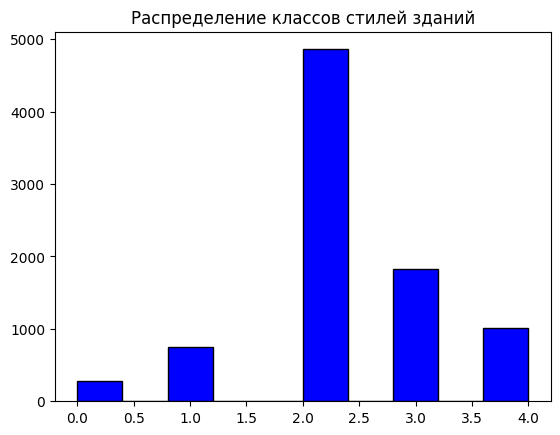

In [ ]:
plt.hist(labels,  color = 'blue', edgecolor = 'black')
plt.title('Распределение классов стилей зданий')

In [ ]:
age, counts = np.unique(ages, return_counts = True)

Text(0.5, 1.0, 'Распределение зданий по возрастам')

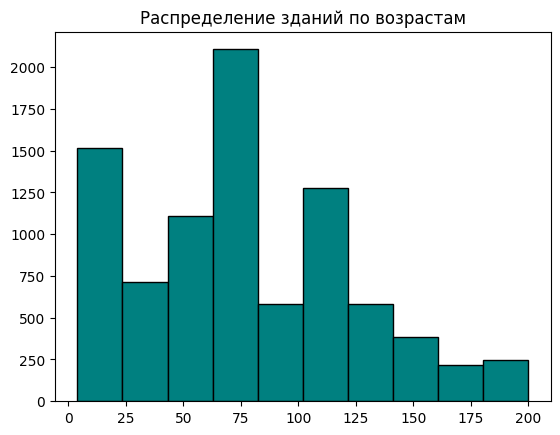

In [ ]:
plt.hist(ages,  color = 'teal', edgecolor = 'black' )
plt.title('Распределение зданий по возрастам')

## ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)

## Обучение моделей

### Архитектурный стиль 

In [ ]:
train_generator_style = datagen.flow(X_train, y_train, batch_size = 32)
test_generator_style = datagen.flow(X_test, y_test, batch_size = 32)

In [ ]:
class NetStyleEffcient:
  @staticmethod
  def build(width, height, depth, classes):
    model_style_eff = Sequential()
    inputShape = (height, width, depth)
    if K.image_data_format() == 'channels_first':
      inputShape = (depth, height, width)

    backbone = EfficientNetB3(input_shape=(255, 255, 3),
    weights='imagenet', include_top=False)

    model_style_eff = Sequential()
    model_style_eff.add(backbone)

    model_style_eff.add(Flatten())
    model_style_eff.add(Dense(1000, activation='selu'))
    model_style_eff.add(Dropout(rate=0.35))
    model_style_eff.add(Dense(classes, activation='softmax'))
    return model_style_eff

In [ ]:
epochs = 5
model_style_eff = NetStyleEffcient.build(width=255, height=255, depth=3, classes=5)
model_style_eff.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_style_eff.fit(train_generator_style, batch_size=64, validation_data=test_generator_style, epochs=epochs)

Epoch 1/5
219/219 [==============================] - 2865s 13s/step - loss: 2.5873 - accuracy: 0.6021 - val_loss: 3.1386 - val_accuracy: 0.5489
Epoch 2/5
219/219 [==============================] - 2765s 13s/step - loss: 1.0462 - accuracy: 0.7064 - val_loss: 1.1490 - val_accuracy: 0.6239
Epoch 3/5
219/219 [==============================] - 2779s 13s/step - loss: 0.8835 - accuracy: 0.7445 - val_loss: 1.4321 - val_accuracy: 0.6039
Epoch 4/5
219/219 [==============================] - 2778s 13s/step - loss: 0.8524 - accuracy: 0.7558 - val_loss: 1.5577 - val_accuracy: 0.5953
Epoch 5/5
219/219 [==============================] - 2754s 13s/step - loss: 0.7541 - accuracy: 0.7717 - val_loss: 0.8786 - val_accuracy: 0.7149


In [ ]:
model_style_eff.save('model_style_eff.keras')

### Возраст зданий

In [ ]:
train_generator_age = datagen.flow(X_train, z_train, batch_size = 32)
test_generator_age = datagen.flow(X_test, z_test, batch_size = 32)

In [ ]:
class Net_Ages:
  @staticmethod
  def build(width, height, depth):
    model_ages = Sequential()
    inputShape = (height, width, depth)
    if K.image_data_format() == 'channels_first':
      inputShape = (depth, height, width)
    model_ages = Sequential()
    
    backbone = ResNet50(input_shape=(255, 255, 3),
    weights='imagenet', include_top=False)

    model_ages.add(backbone)

    model_ages.add(Flatten())
    model_ages.add(Dense(64, activation='selu'))
    model_ages.add(Dense(1, activation='selu')) 
    return model_ages

In [ ]:
epochs = 15
model_ages = Net_Ages.build(width=255, height=255, depth=3)
model_ages.compile(loss='mean_squared_error', optimizer='adam',
               metrics=['mae'])
history_ages = model_ages.fit(train_generator_age, batch_size=64, validation_data=test_generator_age, epochs=epochs)

Epoch 1/15
219/219 [==============================] - 4712s 21s/step - loss: 1932.7186 - mae: 32.2005 - val_loss: 2528.8118 - val_mae: 39.1438
Epoch 2/15
219/219 [==============================] - 4647s 21s/step - loss: 1103.3232 - mae: 25.1230 - val_loss: 3882.4944 - val_mae: 49.3573
Epoch 3/15
219/219 [==============================] - 4648s 21s/step - loss: 963.4229 - mae: 23.2436 - val_loss: 2166.7246 - val_mae: 35.7108
Epoch 4/15
219/219 [==============================] - 4649s 21s/step - loss: 942.1350 - mae: 23.1132 - val_loss: 1609.9519 - val_mae: 30.7584
Epoch 5/15
219/219 [==============================] - 4650s 21s/step - loss: 890.5519 - mae: 22.3497 - val_loss: 947.5304 - val_mae: 23.2544
Epoch 6/15
219/219 [==============================] - 4631s 21s/step - loss: 846.0675 - mae: 21.7976 - val_loss: 1379.1820 - val_mae: 27.8521
Epoch 7/15
219/219 [==============================] - 4656s 21s/step - loss: 842.7543 - mae: 21.5151 - val_loss: 1024.4269 - val_mae: 24.9506
Epoch

In [ ]:
model_ages.save('model_ages_resnet.keras')

## Смотрим результаты

In [ ]:
model_style_new = load_model('model_style_eff.keras')
model_ages_new = load_model('model_ages_resnet.keras')

In [ ]:
predicted_style_new = model_style_new.predict(X_test)
predicted_age_new = model_ages_new.predict(X_test)

55/55 [==============================] - 328s 6s/step


C:\Users\Acer\AppData\Local\Temp\ipykernel_1780\4082540143.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Точно: {int(z_test[index])}, {classes[y_test[index]]}, Предсказано: {int(predicted_age_new[index])}, {classes[np.argmax(predicted_style_new[index])]}')


Text(0.5, 1.0, 'Точно: 122, Эклектика, Предсказано: 142, Эклектика')

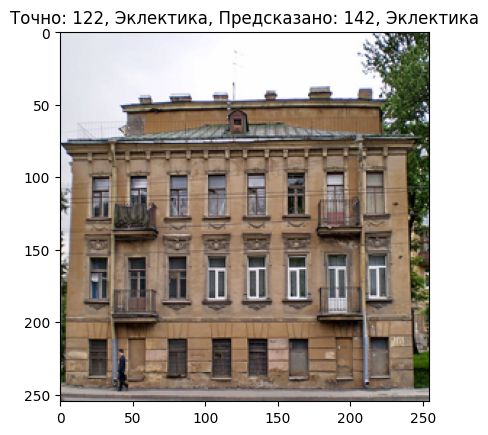

In [ ]:
index = 1354
plt.imshow(X_test[index])
plt.title(f'Точно: {int(z_test[index])}, {classes[y_test[index]]}, Предсказано: {int(predicted_age_new[index])}, {classes[np.argmax(predicted_style_new[index])]}')